In [3]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model
data=pd.read_csv('july-dataset4.csv')
humidity = data['Humidity']
Epoch_Time = data['Epoch_Time']
Cloud_Cover = data['Cloud_Cover']
Dew_Point = data['Dew_Point']
Humidity = data['Humidity']
Pressure = data['Pressure']
Temperature = data['Temperature']
Wind_Speed = data['Wind_Speed']
Visibility = data['Visibility']

In [1]:
def spliting_data(df, training_percent = 0.7, validation_percent = 0.15, testing_percent = 0.15, seed = None):
    np.random.seed(seed)
    total_size = training_percent + validation_percent + testing_percent
    if total_size != 1:
        raise ValueError('total size must be 1 not {}'.format(total_size))
    training_end = int(training_percent * len(df))
    validate_end = int(validation_percent * len(df)) + training_end
    perm = np.random.permutation(df.index) # randomize indexs
    training = perm[:training_end]
    validate = perm[training_end:validate_end]
    testing = perm[validate_end:]
    return training, validate, testing

In [5]:
training,validate,testing = spliting_data(data)

In [6]:
df = pd.DataFrame(data, columns=[
        'Epoch_Time','Cloud_Cover','Dew_Point',
        'Humidity','Pressure','Temperature','Wind_Speed','Visibility',
        'Power_Output'])
label_col = 'Power_Output'

In [7]:
y_train = df.loc[training, [label_col]]
x_train = df.loc[training, :].drop(label_col, axis=1)
y_valid = df.loc[validate, [label_col]]
x_valid = df.loc[validate, :].drop(label_col, axis=1)

print('Size of training set: ', len(x_train))
print('Size of validation set: ', len(x_valid))
print('Size of test set: ', len(testing), '(not converted)')

Size of training set:  6249
Size of validation set:  1339
Size of test set:  1340 (not converted)


In [8]:
def norm_stats(df1, df2):
    dfs = df1.append(df2)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)

def z_score(col, stats):
    m, M, mu, s = stats
    df2 = pd.DataFrame()
    for c in col.columns:
        df2[c] = (col[c]-mu[c])/s[c]
    return df2

stats = norm_stats(x_train, x_valid)
arr_x_train = np.array(z_score(x_train, stats))
arr_y_train = np.array(y_train)
arr_x_valid = np.array(z_score(x_valid, stats))
arr_y_valid = np.array(y_valid)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])

Training shape: (6249, 8)
Training samples:  6249
Validation samples:  1339


In [9]:
def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model)

In [10]:
model = basic_model_3(arr_x_train.shape[1], arr_y_train.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                720       
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               9720      
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2420      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
__________

In [20]:
epochs = 250
batch_size = 32

print('Epochs: ', epochs)
print('Batch size: ', batch_size)
keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

Epochs:  250
Batch size:  32


In [21]:
history = model.fit(arr_x_train, arr_y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=2, # Change it to 2, if wished to observe execution
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

Train on 6249 samples, validate on 1339 samples
Epoch 1/250
 - 0s - loss: 35974758.0323 - mean_absolute_error: 3795.6491 - val_loss: 28840854.6378 - val_mean_absolute_error: 3281.2168
Epoch 2/250
 - 0s - loss: 35377795.5929 - mean_absolute_error: 3772.8530 - val_loss: 24006319.1128 - val_mean_absolute_error: 2798.8250
Epoch 3/250
 - 0s - loss: 36102407.0030 - mean_absolute_error: 3858.3892 - val_loss: 23694865.1113 - val_mean_absolute_error: 2739.4458
Epoch 4/250
 - 0s - loss: 35907932.6645 - mean_absolute_error: 3806.4455 - val_loss: 23768211.0948 - val_mean_absolute_error: 2740.9374
Epoch 5/250
 - 0s - loss: 36004908.5353 - mean_absolute_error: 3797.6419 - val_loss: 23078148.6243 - val_mean_absolute_error: 2718.0266
Epoch 6/250
 - 0s - loss: 34606012.5803 - mean_absolute_error: 3706.4598 - val_loss: 23103868.9141 - val_mean_absolute_error: 2706.4294
Epoch 7/250
 - 0s - loss: 35096113.4937 - mean_absolute_error: 3751.3420 - val_loss: 24593504.2450 - val_mean_absolute_error: 2856.4883


Epoch 61/250
 - 0s - loss: 32959772.2829 - mean_absolute_error: 3632.2224 - val_loss: 22639053.6102 - val_mean_absolute_error: 2777.9670
Epoch 62/250
 - 0s - loss: 32402577.6412 - mean_absolute_error: 3546.9906 - val_loss: 21028796.0597 - val_mean_absolute_error: 2566.9625
Epoch 63/250
 - 0s - loss: 32592718.6724 - mean_absolute_error: 3594.1411 - val_loss: 21507340.5527 - val_mean_absolute_error: 2596.5508
Epoch 64/250
 - 0s - loss: 32596652.4186 - mean_absolute_error: 3560.1027 - val_loss: 20364977.4653 - val_mean_absolute_error: 2482.8220
Epoch 65/250
 - 0s - loss: 32203034.1924 - mean_absolute_error: 3564.0335 - val_loss: 22064937.8372 - val_mean_absolute_error: 2682.2009
Epoch 66/250
 - 0s - loss: 32131674.5226 - mean_absolute_error: 3545.2306 - val_loss: 23002573.8223 - val_mean_absolute_error: 2771.5927
Epoch 67/250
 - 0s - loss: 30889298.8741 - mean_absolute_error: 3483.0863 - val_loss: 21598452.4705 - val_mean_absolute_error: 2571.1231
Epoch 68/250
 - 0s - loss: 31355141.4001 

In [22]:
train_score = model.evaluate(arr_x_train, arr_y_train, verbose=2)
valid_score = model.evaluate(arr_x_valid, arr_y_valid, verbose=2)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  2402.7449 , Train Loss:  17834303.8375
Val MAE:  2442.3199 , Val Loss:  19500662.0493


In [23]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

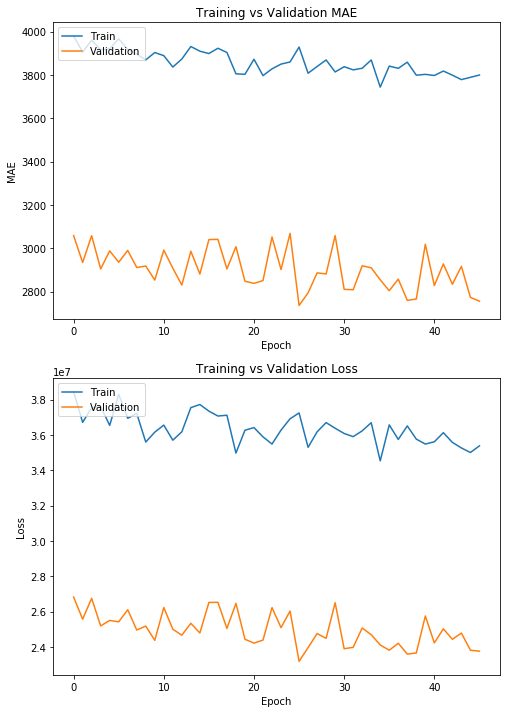

In [19]:
plot_hist(history.history, xsize=8, ysize=12)